<a href="https://colab.research.google.com/github/rheazh/Data-Analysis/blob/main/Rhea's_Unit_5_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### How does the population of a country affect its green house gas emissions?

In [1]:
#importing all the stuff
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm

from scipy.interpolate import PchipInterpolator

In [2]:
url_grn = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/greenhousegas_pop_10nations.csv'

In [3]:
#data
grn = pd.read_csv(url_grn)
grn

,country,code,year,grnGasEm100K,pop10M
0,Brazil,BRA,1970,12.6098,9.5982
1,Canada,CAN,1970,4.9497,2.1324
2,China,CHN,1970,18.7397,81.8315
3,Germany,DEU,1970,12.8657,7.8169
4,France,FRA,1970,6.1450,5.2035
...,...,...,...,...,...
425,United Kingdom,GBR,2012,5.8578,6.3700
426,India,IND,2012,30.0289,126.3590
427,Japan,JPN,2012,14.7886,12.7561
428,Mexico,MEX,2012,6.6342,12.2071


In [4]:
pop = pd.read_csv(url_grn)

<Axes: xlabel='pop10M', ylabel='grnGasEm100K'>

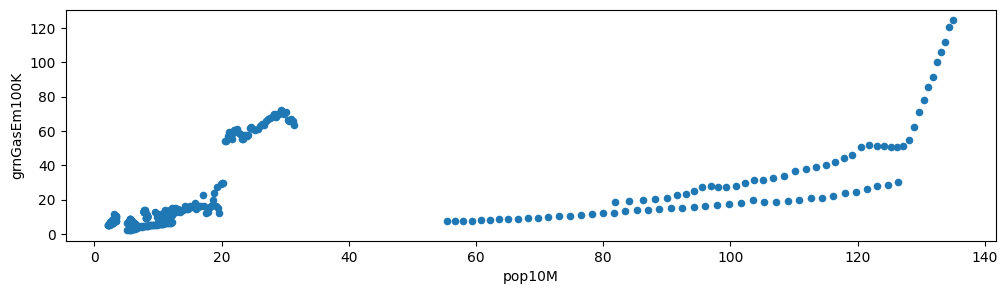

In [5]:
#create scatter plot for greenhouse gasses v. population.
pop.plot(x="pop10M", y="grnGasEm100K", figsize=(12, 3), kind="scatter")

This creates a scatter plot of the population (in tens of millions, pop10M) versus the greenhouse gas emissions per 100,000 people (grnGasEm100K) to visualize the relationship between the two variables.

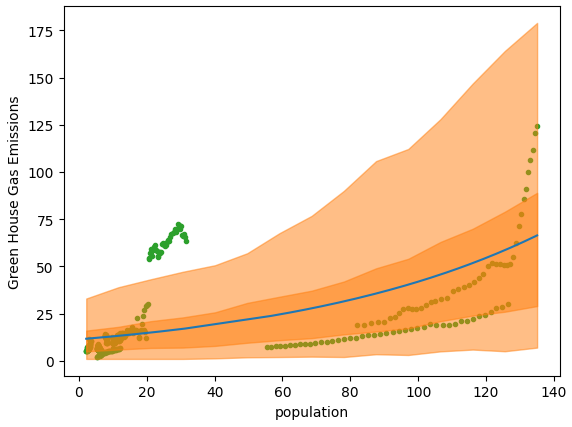

I ran through all the code for this data set and ended up with this graph. However, I realized that since the population jump was so big from around 30 to 50, and since the dataset included highly industrialized countries like the U.S and China, it was almost like there were two things happening at once.

In [6]:
#filtering the data
grn = grn.query('pop10M < 40.6')

I decided to take the average population of all the countries (which ended up being about 40.6) and removed all the counties with a higher population than that from the data set so that I could narrow it down a bit and it would be easier to work with.

<Axes: xlabel='pop10M', ylabel='grnGasEm100K'>

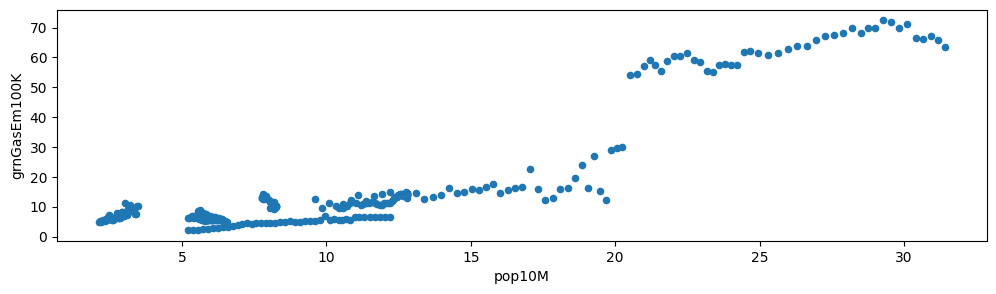

In [7]:
#scatter plot of population v. green house gas emissions (100K)
grn.plot(x="pop10M", y="grnGasEm100K", figsize=(12, 3), kind="scatter")

I plotted the filtered data again to check the updated visualization of the relationship between population and greenhouse gas emissions. I think it looks much better and will be easier to work with.

In [8]:
with pm.Model() as model_grn:

    #priors for the linear part of our model
    α = pm.Normal("α", mu=0, sigma=100)
    β = pm.Normal("β", mu=0, sigma=10)

    #this is the linear part of our model
    μ = pm.Deterministic("μ", α + β * grn.pop10M)

    #prior for the standard deviation of our likelihood
    #Cauchy is a T dist with nu = 1
    σ = pm.HalfCauchy("σ", 10)

    #likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=grn.grnGasEm100K)

    #inference data object
    idata_grn = pm.sample()

Output()

Output()

sets priors for the model's parameters using normal and Half-Cauchy distributions to represent uncertainty.

array([<Axes: title={'center': 'α'}>, <Axes: title={'center': 'β'}>,
       <Axes: title={'center': 'σ'}>], dtype=object)

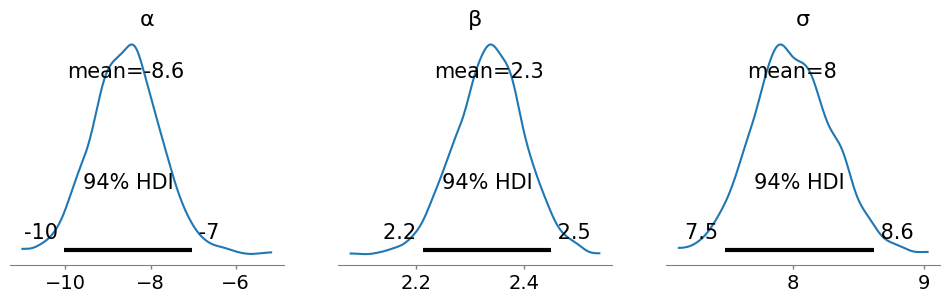

In [9]:
#plot of the posteriors
az.plot_posterior(idata_grn, var_names=["~μ"], figsize=(12, 3))

visualize the posterior distribution of the model's predicted relationship between population and greenhouse gas emissions.

α = -8.6: The baseline value of emissions when population is 0 is expected to be around -8.6, with uncertainty about this estimate based on the posterior distribution.

β = 2.3: For each unit increase in population, the model expects emissions to increase by 2.3 units, suggesting a positive relationship between the two values

σ = 8: The data points for emissions are expected to deviate from the predicted values (μ) by approximately 8 units on average, indicating substantial variability in the data.

Text(0, 0.5, 'Green House Gas Emissions')

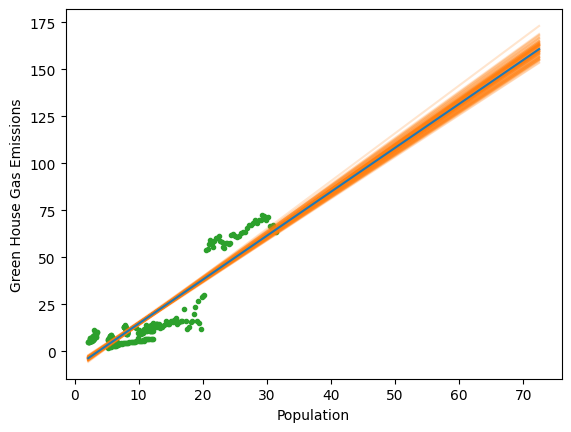

In [10]:
#grabs 100 posterior samples
posterior = az.extract(idata_grn, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(grn.pop10M.min(), grn.grnGasEm100K.max(), 50),
    dims="plot_id"
    )

# this creates the expected line, the path we predict population and green house gas count deviates from
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

#These are a 50 lines that our model came up with
lines = posterior["α"] + posterior["β"] * x_plot

#set up plot
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, mean_line, c="C0", label="mean line")

#plot the raw data
ax.plot(grn.pop10M, grn.grnGasEm100K, "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("Population")
ax.set_ylabel("Green House Gas Emissions")

The mean line shows the expected regression line based on the average values of these parameters, while the raw data points are overlaid to show how the observed data fits within the model’s predicted range. The data points here are not really aligning with the posterior or mean line so it clearly needs adjustment.

In [11]:
pm.sample_posterior_predictive(idata_grn, model=model_grn,  extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'Green House Gas Emissions')

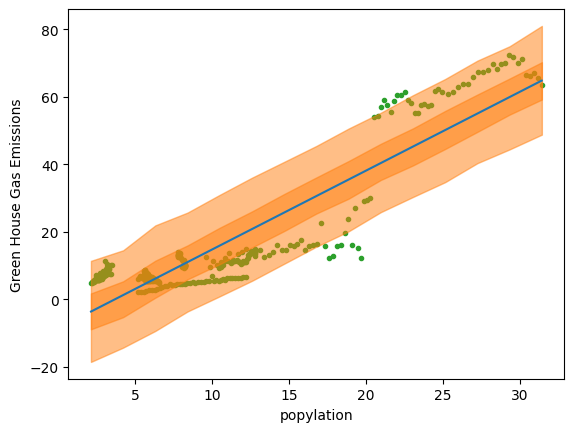

In [12]:
#plots the posterior predictive distribution

#grabs the expected line, or line of best fit formula
mean_line = idata_grn.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
populations = np.random.normal(grn.pop10M.values, 0.01)
idx = np.argsort(populations)
x = np.linspace(populations.min(), populations.max(), 15)

#grabs the 94% HDIs, and sets them up for graphing.
y_pred_q = idata_grn.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(populations[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(grn.pop10M, grn.grnGasEm100K, "C2.", zorder=-3)
ax.plot(grn.pop10M.to_numpy()[idx], mean_line.to_numpy()[idx], c="C0")


#graphs the 94% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("popylation")
ax.set_ylabel("Green House Gas Emissions")

I plot the posterior predictive distribution. Since most of the data points dont lie on the mean line, but still lie within the shaded regions, the model is capturing the general trend between population and greenhouse gas emissions, but there is some inherent variability in the data that the model can’t perfectly account for.

<Axes: xlabel='y_pred'>

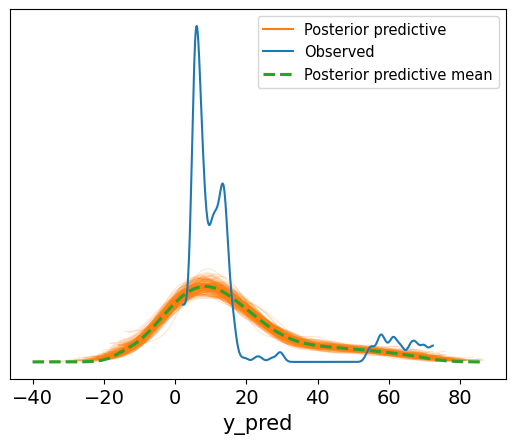

In [19]:
az.plot_ppc(idata_grn, num_pp_samples=200, colors=["C1", "C0", "C2"])

I plotted the posterior predictive check which shows how well the model's predictions align with the actual observed data. Clearly the observed line is not aligning with the posterior predictive very well so the model is probably doing a horrible job capturing the true relationship in the data.

<Axes: ylabel='grnGasEm100K'>

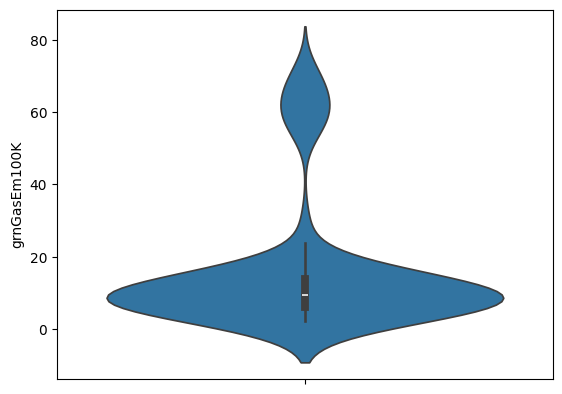

In [14]:
#plot violin graph
sns.violinplot(grn.grnGasEm100K)

Here is the violin plot. You can see there is a sort of positive skew here.

In [15]:
with pm.Model() as model_ghs:

    #priors for the linear part of the model
    α = pm.Normal("α", mu=0, sigma=1)
    β = pm.Normal("β", mu=0, sigma=10)

    #the linear part of our model,
    #but with a twist:
    #our line is exponentiated, in order to make our all our values positive
    μ = pm.Deterministic("μ", pm.math.exp(α + β * grn.pop10M))

    #prior for the likelihood's standard deviation
    σ = pm.HalfNormal("σ", 10)

    #likelihood
    y_pred = pm.NegativeBinomial("y_pred", mu=μ, alpha=σ, observed=grn.grnGasEm100K)

    idata_ghs = pm.sample()


Output()

Output()

This estimates how population influences emissions, using a negative binomial distribution to account for count data variability. Models the emissions as a function of population, while accounting for uncertainty in both the data and the model.

In [16]:
pm.sample_posterior_predictive(idata_ghs, model = model_ghs, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

This generates new predictions from the model based on the model's learned parameters, and adds these predictions to the existing results for further analysis.

<Axes: xlabel='y_pred'>

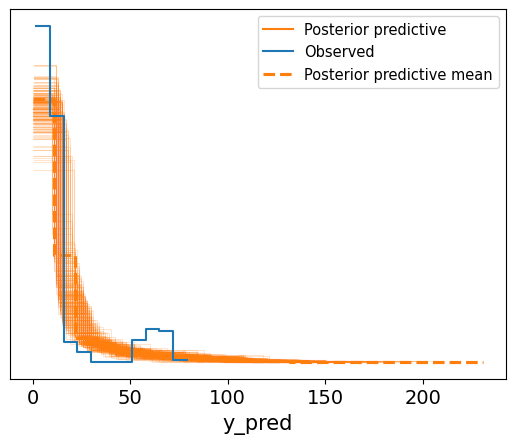

In [17]:
#plot PPC
az.plot_ppc(idata_ghs, num_pp_samples=200, colors=["C1", "C0", "C1"])

This model aligns much better than the other one. Since the observed dosen't match up perfectly, it seems that the model is capturing the overall trend or pattern in the data, but there is some uncertainty or variability in the its predictions.

Text(0, 0.5, 'Green House Gas Emissions')

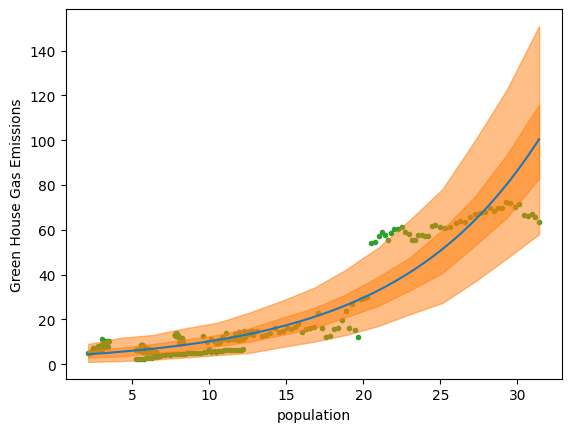

In [22]:
# Calculate the mean of the posterior samples for the predicted emissions
mean_line = idata_ghs.posterior["μ"].mean(("chain", "draw"))

# Generate 'temperature' values based on population
temperatures = np.random.normal(grn.pop10M.values, 0.01)

# Sort the population values for better plotting
idx = np.argsort(populations)

# Create a set of x-values (population) for plotting the predictions
x = np.linspace(populations.min(), populations.max(), 15)

# Calculate the quantiles (3rd, 97th, 25th, 75th percentiles) of the posterior predictive samples (y_pred)
y_pred_q = idata_ghs.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)

y_hat_bounds = iter(
    [
        PchipInterpolator(populations[idx], y_pred_q[i][idx])(x)  # Interpolate for each quantile bound
        for i in range(4)
    ]
)

# Create a plot
_, ax = plt.subplots()

# Plot the observed data (population vs. emissions) as points (color 'C2')
ax.plot(grn.pop10M, grn.grnGasEm100K, "C2.", zorder=-3)

# Plot the mean predicted emissions line (color 'C0')
ax.plot(grn.pop10M.to_numpy()[idx], mean_line.to_numpy()[idx], c="C0")

# Plot the uncertainty bounds (shaded areas) for the quantiles of the predictions
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)  # Filling the area between quantile bounds

# Set the labels for the x and y axes
ax.set_xlabel("population")
ax.set_ylabel("Green House Gas Emissions")


This model matches pretty well in my opinion. Since most of the data points lie within the shaded region, the model is doing a good job of capturing the underlying relationship between population and greenhouse gas emissions.

 the general shape of the graph is an increasing exponential, which might suggest that the relationship between population and greenhouse gas emissions is not just linear, but rather exponentially increasing. This means that as the population of a country increases, the greenhouse gas emissions grow at an accelerating rate, not just in a straight-line manner. As the population grows, the emissions increase, but the rate of increase becomes faster.